## Introduction

This is an amateur attempt at bulding my first NLP project, inspired by the FastAI 2022 course I'm currently enrolled in.

Please note that this notebook is for learning purposes and I borrow heavily from Jeremy Howards's excellent beginner-guide to NLP with transformers. Jeremy's notebook can be found [here](https://www.kaggle.com/code/jhoward/getting-started-with-nlp-for-absolute-beginners). 

If you find this notebook remotely useful, please upvote that original notebook too. 

I also took a lot of help from the Chapter two of the popular [NLP with Transformers](https://github.com/nlp-with-transformers) book, which also tackle a tweet classification problem. The link is to their github repo, which has the whole book as notebooks! 


> *TweetEval consists of seven heterogenous tasks in Twitter, all framed as multi-class tweet classification. The tasks include - irony, hate, offensive, stance, emoji, emotion, and sentiment. All tasks have been unified into the same benchmark, with each dataset presented in the same format and with fixed training, validation and test splits.*

I choose the `stance_abortion` subset, which classifies a bunch of tweets on abortion, according to their stance on abortion: `0` says 'none' or neutral, `1` says that the tweet is favoring abortion, and `2` says that a tweet is against abortion. So, its a text-classification problem.

## Import Libraries

- First let's download/import the needed libraries, including the hugging face datasets:

In [53]:
! pip install -q datasets

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import Dataset,DatasetDict

We'll need to import other stuff, but we'll do it as we need them.

Next, I'll set the display width of a pandas dataframe, so that we are able to see more of the contents of our data.

In [55]:
#pd.set_option('display.width', 1500)
pd.set_option('max_colwidth', 800)

## Getting data into Jupyter



In [56]:
from datasets import load_dataset

Let's load the dataset.

So I first tried to just load the `tweet_eval`, but python threw an error, and pointed out to me that I should specify the subset. How helpful is that for a noob like me! Look at the SS with the error:

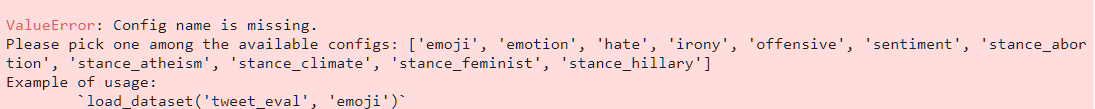

In [57]:
abortion = load_dataset("tweet_eval", 'stance_abortion')

  0%|          | 0/3 [00:00<?, ?it/s]

## Exploratory Data Analysis(EDA)

Let's just run the dataset we loaded, and see what the output is:

In [58]:
abortion

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 587
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 280
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 66
    })
})

So, unlike a pandas dataframe which outputs its contents when executed, huggingface dataset outputs the structure of its contents, in a dictionary format. 

You can see they have three separate sets, train, test and valid. 

- Train is the training set we use to train our model. 
- valid is the validation set we use to evaluate our model, from time to time, to evaluate the performance of our model. 
- Lastly, test is the test set. We separate it at the beginning of any project, and never look at it until we are satisified with the perfomance of our model, and ready to deploy it. 

There is a good explanation of this in the above kaggle notebook by Jeremy. Also, Rachel Thomas, a co-founder of fastai, wrote [this awesome blogpost](https://www.fast.ai/2017/11/13/validation-sets/) on how and why it's important to choose a proper validation set.

We can access the `train` set as follows:

In [59]:
train_ds = abortion['train']
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 587
})

What are the column names? They are represented as the values of the `features` key:

In [60]:
train_ds.column_names

['text', 'label']

This shows the fact that huggingface Datasets is
based on *Apache Arrow*, which defines a typed columnar format that is more memory
efficient than native Python. You can see the data types of the columns by accessing the `features` attribute:

In [61]:
train_ds.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(num_classes=3, names=['none', 'against', 'favor'], id=None)}

Let's now convert our dataset into a *pandas dataframe* which enables us to explore and visualise it more easily.

Here's what *NLP with Transformers* say about it:

>*To enable the conversion, Datasets
provides a set_format() method that allows us to change the output format of
the Dataset. Note that this does not change the underlying data format (which is an
Arrow table)*

In [62]:
abortion.set_format(type='pandas')
df = abortion['train'][:]

In [63]:
df.head(10)

,text,label
0,we remind ourselves that love means to be willing to give until it hurts - Mother Teresa,1
1,"@user @user and most Islanders have different definitions of ""timely access"". #irony #peipoli #peivotes",0
2,"Life is #precious & so are babies, mothers, & fathers. Please support the sanctity of Human Life. Think #SemST",1
3,@user too many people are taking this to seriously #SemST,0
4,Dude i won a #freeshirt from @user ! I never win anything lol #Abort73 #SemST,0
5,Like ya'll can try and push your views on me anyway but I will remain #SemST,0
6,Just because it is legal doesn't make it God honoring #SameSexMarriage #180themovie #AudacityMovie #SemST,0
7,@user maybe that's what he wants #SemST,0
8,If being in a mother's womb isn't safe I guess neither are churches; specifically black ones #WhoIsBurningBlackChurches #SemST,1
9,"@user @user Nothing to do with me. It's not my choice, nor is it yours, to dictate what another woman chooses. #feminism #SemST",2


### Descriptive statistics of tweets
Describe method gives decriptive stastics of the columns of a dataframe. As we saw above, we habe one "string" type column, and lets describe it:

In [64]:
df.describe(include='object')

,text
count,587
unique,587
top,we remind ourselves that love means to be willing to give until it hurts - Mother Teresa
freq,1


We can see there are 587 unique tweets in the dataset, and every tweet occurs only once. 

### Getting the names of the labels

Let's now look at what these 'labels' actually mean. We'll use `int2str` method of huggingface datasets to access the names of the labels:

In [65]:
def get_label_names(row):
    return abortion['train'].features['label'].int2str(row)

df['label name'] = df['label'].apply(get_label_names)
df.head(10)
    
    

,text,label,label name
0,we remind ourselves that love means to be willing to give until it hurts - Mother Teresa,1,against
1,"@user @user and most Islanders have different definitions of ""timely access"". #irony #peipoli #peivotes",0,none
2,"Life is #precious & so are babies, mothers, & fathers. Please support the sanctity of Human Life. Think #SemST",1,against
3,@user too many people are taking this to seriously #SemST,0,none
4,Dude i won a #freeshirt from @user ! I never win anything lol #Abort73 #SemST,0,none
5,Like ya'll can try and push your views on me anyway but I will remain #SemST,0,none
6,Just because it is legal doesn't make it God honoring #SameSexMarriage #180themovie #AudacityMovie #SemST,0,none
7,@user maybe that's what he wants #SemST,0,none
8,If being in a mother's womb isn't safe I guess neither are churches; specifically black ones #WhoIsBurningBlackChurches #SemST,1,against
9,"@user @user Nothing to do with me. It's not my choice, nor is it yours, to dictate what another woman chooses. #feminism #SemST",2,favor


#### `Apply()` method of pandas

> ### Aside: What is .apply() method all about? Let's look at pandas documentation on it:
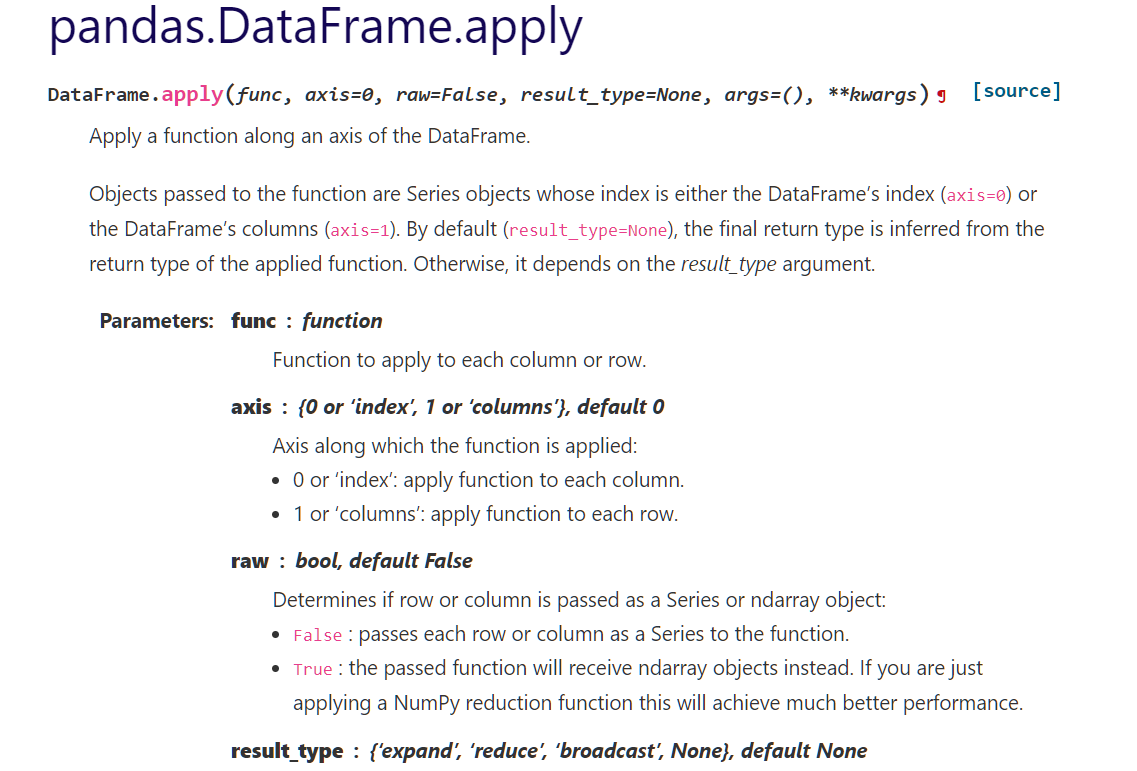
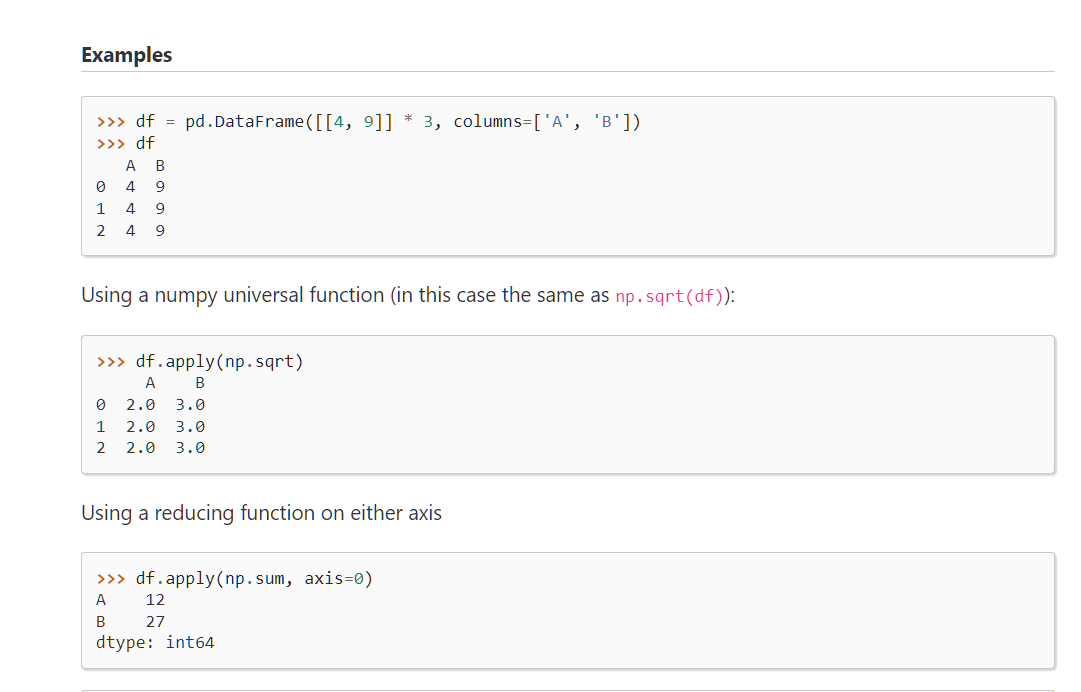
    

### Frequencies of label classes - Checking for imbalance

Next, since this is a classification problem, it's a good idea to check the relative frequencies of our classes, or labels. If the classes are 'imbalanced', meaning their frquencies are not atleast roughly equal, then we need to address the problem, because it can affect the performance of the model. It can be biased towards the more frequent class, for example. There are atleast 3 ways to address this issue:

- Randomly oversample the minority class eg: SMOTE oversampling method - Python has a library known as `imbalanced-learn` which makes our lives easier if we want to do over or undersampling of a dataset in a proper way. Check [this cool article](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/) by machinlearningmastery.com

- Randomly undersample the majority class

- Collect more data for the minority class(es)

[Text(0, 0, 'neutral'),
 Text(1, 0, 'for abortion'),
 Text(2, 0, 'against abortion')]

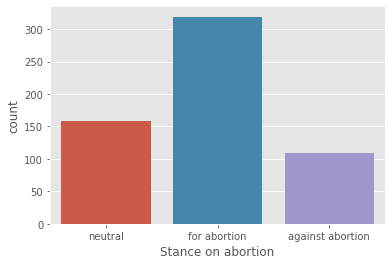

In [66]:
plt.style.use('ggplot')
g = sns.countplot(x='label', data=df)
g.set_xlabel("Stance on abortion")
g.set_xticklabels(['neutral', 'for abortion', 'against abortion'])

So, there's a clear class imbalance we need to address. For abortion tweets are twice more frequent than neutral ones. Tweets against abortion are even less. For this first iteration, we'll model the data as it is to keep things simple. We'll address this problem in the next iteration.

### Checking the word counts of tweets: Transformers have limits!

One of the pros of using transformers is that they have something called **'maximum context size'**, that is they have a limit on the input text sequence, which differs according to the model used. I'm going to use `DistillBERT` model for this analysis, which is a language model similar to Bert, but simpler. This choice is recommended by the NLP with Transformers authors for their tweet classification problem in chapter 2. 

Maximum context size for DistilBert is 512 tokens. Will see what tokens are later, but that's roughly equal to few paragraphs of text. By the look of it, our tweets are much smaller, so we should be fine. Let's check the word counts anyway.

In [67]:
df['word count'] = df.text.str.split().apply(len)

In [68]:
df.head()

,text,label,label name,word count
0,we remind ourselves that love means to be willing to give until it hurts - Mother Teresa,1,against,17
1,"@user @user and most Islanders have different definitions of ""timely access"". #irony #peipoli #peivotes",0,none,14
2,"Life is #precious & so are babies, mothers, & fathers. Please support the sanctity of Human Life. Think #SemST",1,against,19
3,@user too many people are taking this to seriously #SemST,0,none,10
4,Dude i won a #freeshirt from @user ! I never win anything lol #Abort73 #SemST,0,none,15


So we are well within DistillBERT's maximum context size!

But we can't pass the texts directly into a model. A deep learning model expects numbers as inputs, not English sentences! So we need to do two things:

- *Tokenization*: Split each text up into words (or actually, as we'll see, into *tokens*)
- *Numericalization*: Convert each word (or token) into a number.

The details about how this is done actually depend on the particular model we use. So first we'll need to pick a model. Okay, so we've already picked `DistilBERT`, so let's define it and use it for our first iteration. Before going to it, let's reset our output format since we don't need a dataframe for now.

In [69]:
abortion.reset_format()

In [70]:
model_nm = 'distilbert-base-uncased'

`AutoTokenizer` will create a tokenizer appropriate for a given model:

In [71]:
from transformers import AutoModelForSequenceClassification,AutoTokenizer
tokz = AutoTokenizer.from_pretrained(model_nm)

loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.18.0",
  "vocab_size": 30522
}

loading file https://huggingface.co/distilbert-base-uncased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/0e1bbfda7f63a99bb52e3915dcf10

Here's an example of how the tokenizer splits a text into "tokens" (which are like words, but can be sub-word pieces, as you see below):

In [72]:
tokz.tokenize("G'day folks, I'm Nival Kolambage and I'm learning NLP! :)")

['g',
 "'",
 'day',
 'folks',
 ',',
 'i',
 "'",
 'm',
 'ni',
 '##val',
 'ko',
 '##lam',
 '##bag',
 '##e',
 'and',
 'i',
 "'",
 'm',
 'learning',
 'nl',
 '##p',
 '!',
 ':',
 ')']

In [73]:
tokz.tokenize("A platypus is an ornithorhynchus anatinus.")

['a',
 'pl',
 '##at',
 '##yp',
 '##us',
 'is',
 'an',
 'or',
 '##ni',
 '##thor',
 '##hy',
 '##nch',
 '##us',
 'ana',
 '##tin',
 '##us',
 '.']

Here's a simple function which tokenizes our inputs:

In [74]:
def tok_func(x): return tokz(x["text"], padding=True)

To run this quickly in parallel on every row in our dataset, use `map`:

**N:**

`map` is a method of huggingface dataset object. Here's a very easy to understand explanation from their docs:

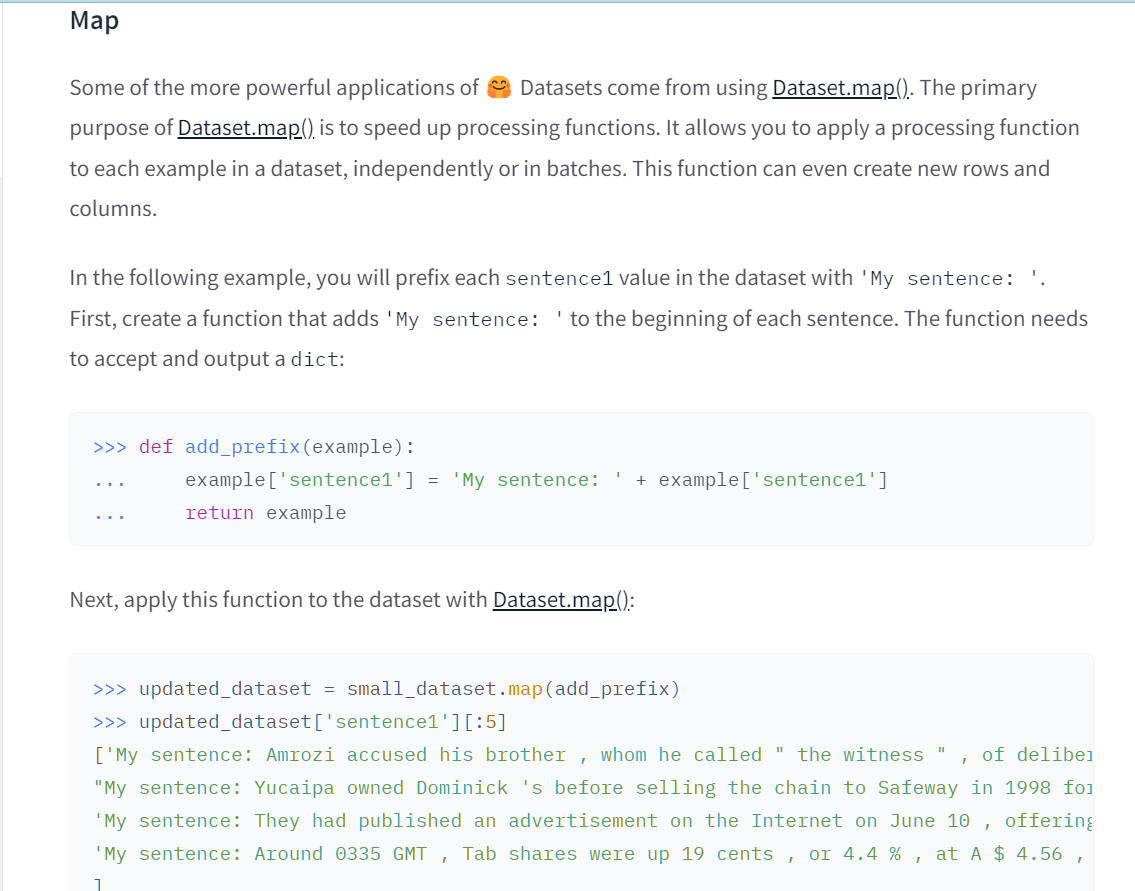

In [75]:
abortion_encoded = abortion.map(tok_func, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

This adds a new item to our dataset called `input_ids`. For instance, here is the input and IDs for the first row of our data:

In [76]:
row = abortion_encoded['train'][0]
print(row)

{'text': 'we remind ourselves that love means to be willing to give until it hurts - Mother Teresa', 'label': 1, 'input_ids': [101, 2057, 10825, 9731, 2008, 2293, 2965, 2000, 2022, 5627, 2000, 2507, 2127, 2009, 13403, 1011, 2388, 12409, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}


**So what are the Zeros at the end of the input id list? And what is this *'attention_mask'* at the end??**


Well, recall that when we defined the tokz function above, we added padding=True, this is because when we are converting these numbers into tensors(which is what a neural network need), every input tweet needs to be of same length, so with padding we are adding zeros at the end of the inputs, to match the longest tweet in the dataset. Attention mask is there to indicate just that. Observe that the zeros in the attention mask start at the same index where there are zeros in the input_ids. I guess we'll discuss this more in a future post.

Below you can see by accessing .vocab attribute, you can locate the token for a given word/subword:

In [77]:
tokz.vocab['##nch']

12680

Now that we've prepared our tokens and labels, It's time to train our model! Oh, wait, first we need to define our Metrics: these are the evaluation parameters the we use to assess the performance of our model. It may be a simple classification accuracy(how many the model got correct overall), or a bit more complicated than that. 

## Metrics

For our problem, we'll use classification accuracy(or just accuracy), and the F1 score-which is a measure of the model's precision and recall. Huggingface expects to return these metrics as a dictionary, and in the NLP with transformers book, they have defined a nice little function which we'll use (the functions for metrics are imported from scikit-learn library):

In [78]:
from sklearn.metrics import accuracy_score, f1_score

In [79]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, "f1" : f1}

## Training our Model

So, as mentioned above, we are using a pretrained model `DistilBERT` to train our tweet classifier.

`AutomodelForSequenceClassfication` of huggingface library not only allows us to load pretrained weights from the model we need, but to fine-tune it to our need.

We just need to tell it how many labels we need to classify. In our case, there are 3 labels:

In [80]:
import torch

In [81]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [82]:
from transformers import AutoModelForSequenceClassification

In [83]:
num_labels = 3
model = (AutoModelForSequenceClassification.from_pretrained(model_nm, num_labels=num_labels).to(device))

loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.18.0",
  "vocab_size": 30522
}

loading we

Before we go and train our model, we need to do two things:

1. **Define our hyperparameters** - There are several arguements we need to define. But I'll right now only worry about three of them: batch size, number of epochs(one epoch is when model has gone through every sample of the training set once), and the learning rate.  Please do refer to this notebook where Jeremy guides us in training a neural network from scratch, and on why learning rate is so important. I also found This notebook from FastAI 2020 course really helpful in understanding above concepts.


2. **Saving and sharing our model with the community** - I'm choosing huggingface hub to do this, we can also setup an inference API through the hub, and have a simple GUI interface to test our model!



We'll import `TrainingArguments` and `Trainer`. Former allows us to define the arguments to feed into the latter, and the latter is the class we use for training!

In [84]:
from transformers import TrainingArguments, Trainer

Let's define the 3 hyperparameteres I mentioned above:

In [85]:
learning_rate = 5e-5
batch_size = 64
epochs = 6

Let's instantiate a TrainingArguments object with all the hyperparameters needed. I'm using all the ones exactly as in the Ch2 of the NLP with Transformers book, as they too tackle a tweet classfication problem. 

In [86]:
#logging_steps = len(abortion_encoded['train'])//batch_size
#model_name = f"{model_nm}-finetuned-abortion"

In [87]:
arguments = TrainingArguments(output_dir=model_name, learning_rate=learning_rate, 
                                fp16=True, evaluation_strategy="epoch", 
                                per_device_train_batch_size=batch_size, per_device_eval_batch_size=batch_size,
                                num_train_epochs=epochs, weight_decay=0.01, 
                                disable_tqdm=False
                               )

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [88]:
trainer = Trainer(model=model, args=arguments, train_dataset=abortion_encoded['train'], eval_dataset=abortion_encoded['validation'],
                  tokenizer=tokz, compute_metrics=compute_metrics)

Using amp half precision backend


In [89]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 587
  Num Epochs = 6
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 60
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.924442,0.545455,0.385027
2,No log,0.711459,0.712121,0.638961
3,No log,0.587853,0.742424,0.716769
4,No log,0.543469,0.757576,0.761205
5,No log,0.553122,0.757576,0.763864
6,No log,0.557628,0.757576,0.763864


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 66
  Batch size = 64
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 66
  Batch size = 64
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 6

TrainOutput(global_step=60, training_loss=0.6131579081217448, metrics={'train_runtime': 10.2975, 'train_samples_per_second': 342.024, 'train_steps_per_second': 5.827, 'total_flos': 44651106285156.0, 'train_loss': 0.6131579081217448, 'epoch': 6.0})

When you run the above cell, it'll also ask for a weights & biases API key, for reasons I'm not too sure of. But it's easy to signup for an account there and get your key, for free.

Ok, so as I told, we'll only worry about 3 hyperparameters for now: learning rate, number of epochs, and batch size. I found the above learning rate to work relatively well, after trying with few different ones. Let's try to train a little more with a lower lr. I wrapped the arguments and trainer in a small function so that we can experiment easily with the three hyperparameters we want to change::

In [90]:
def model_train(lr, bs, epochs):
    arguments = TrainingArguments(output_dir=model_name, learning_rate=lr, 
                                fp16=True, evaluation_strategy="epoch", 
                                per_device_train_batch_size=bs, per_device_eval_batch_size=bs,
                                num_train_epochs=epochs, weight_decay=0.01, 
                                disable_tqdm=False, logging_steps=logging_steps 
                               )
    trainer = Trainer(model=model, args=arguments, train_dataset=abortion_encoded['train'], eval_dataset=abortion_encoded['validation'],
                  tokenizer=tokz, compute_metrics=compute_metrics)
    return trainer.train()

In [91]:
model_train(lr=5e-6, bs=64, epochs=2)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using amp half precision backend
The following columns in the training set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 587
  Num Epochs = 2
  Instantaneous batch size 

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.298000,0.567369,0.757576,0.763864
2,0.275000,0.568909,0.757576,0.763864


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 66
  Batch size = 64
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 66
  Batch size = 64


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=20, training_loss=0.27657116651535035, metrics={'train_runtime': 3.4667, 'train_samples_per_second': 338.652, 'train_steps_per_second': 5.769, 'total_flos': 14883702095052.0, 'train_loss': 0.27657116651535035, 'epoch': 2.0})

So it definitely got better, but in the latter epochs, I'm afraid that the validation loss has gotten worse, with training loss improving. Has the model started to overfit? Anyway now I will reduce the learning rate and try to train a little more, since higher learning rate could make our metrics worse or overfit the model, or both.

In [92]:
model_train(lr=8e-6, bs=64, epochs=3)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using amp half precision backend
The following columns in the training set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 587
  Num Epochs = 3
  Instantaneous batch size 

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.258300,0.583703,0.742424,0.749064
2,0.233900,0.599452,0.742424,0.749064
3,0.197700,0.605234,0.742424,0.749064


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 66
  Batch size = 64
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 66
  Batch size = 64
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 6

TrainOutput(global_step=30, training_loss=0.22724132736523947, metrics={'train_runtime': 5.1509, 'train_samples_per_second': 341.881, 'train_steps_per_second': 5.824, 'total_flos': 22325553142578.0, 'train_loss': 0.22724132736523947, 'epoch': 3.0})

So we are able to achieve an accuracy of 77.27% for our model that classifies tweets according to their stance regarding abortion: for, against and neutral. So how good is our model? I tried to find other work on this same dataset provided by huggingface, but I found only one more model on the huggingface hub, which gave a validation loss of 1.1347 and F1 score of 0.72. My results are slightly better than this. Also:

- Tweet stance detection was part of SemEval 2016 competition by the Special Interest Group on the Lexicon of the Association for Computational Linguistics(SIGLEX), and the best model for abortion-stance detection was 'DeepStance' a CNN-based approach which has an [F1 score of 63.32](https://aclanthology.org/S16-1003.pdf) (page 36).

- This paper reported the benchmark as at 2021 March, which is an F1 score of 76.45%, marginally worse than ours. This used what they called a 'weighted K-NN classifier.'

- This ['NLDS-UCSC at SemEval-2016 Task 6: A Semi-Supervised Approach toDetecting Stance in Tweets'](https://arxiv.org/pdf/1709.01895.pdf) gave an overall F1-score of 67% for abortion stance detection. 

So, even though I'm not exactly sure at this point, I think our result is atleast somewhere close to SOTA, and we can definitely improve on this if we experiment more.

We shall now further scrutinize our model using a confusion matrix. This can provide further insights, and see whether its biased towards selecting the majority class. (which is 'for abortion'). To do this, first we need to obtain the predictions from our model:

## Confusion Matrix

Before plotting the confusion matrix, we need to get the predictions and true labels for each tweet into matching arrays, so that we can plot the confusion matrix properly. Also we need class labels to display in the matrix.

In [93]:
preds = trainer.predict(abortion_encoded['validation'])

The following columns in the test set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 66
  Batch size = 64


The metrics on the validation set can be accessed as follows:

In [94]:
preds.metrics

{'test_loss': 0.6052343249320984,
 'test_accuracy': 0.7424242424242424,
 'test_f1': 0.7490635125523564,
 'test_runtime': 0.0855,
 'test_samples_per_second': 772.356,
 'test_steps_per_second': 23.405}

We can access the predictions for the three classes using the predictions attribute, let's see the predictions for the first tweet in the dataset:

In [95]:
preds.predictions[0]

array([-0.1133,  1.194 , -1.601 ], dtype=float16)

We can get the predicted class for each tweet by using np.argmax, which is the most likely class (with highest probability), according to the model.

In [96]:
preds = np.argmax(preds.predictions, axis=1)

Let's see whether our predictions and true labels are in the same shape, i.e. dimensions are the same.

In [97]:
preds.shape

(66,)

In [98]:
y_valid = np.array(abortion_encoded['validation']['label'])

In [99]:
y_valid.shape


(66,)

They are compatible! Let's get the names of the labels:

In [100]:
labels = abortion_encoded['validation'].features['label'].names

In [101]:
labels

['none', 'against', 'favor']

In [102]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [103]:
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds)
    fig, ax = plt.subplots(figsize=(10, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", ax=ax, colorbar=False)
    plt.title("Confusion matrix")
    plt.show()
    

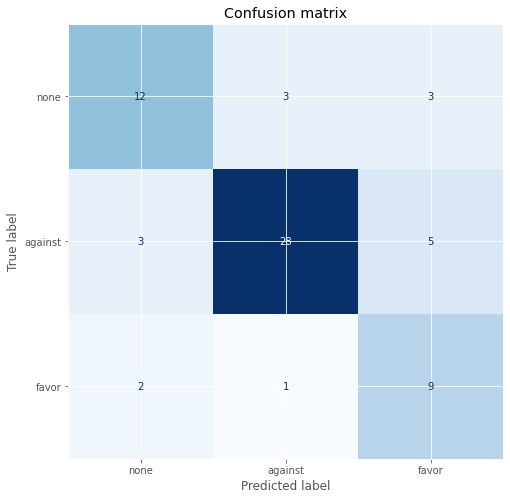

In [104]:
plot_confusion_matrix(preds, y_valid, labels)

So our confusion matrix is failry alright, and shows that the model confuses neutral tweets the most: 4 of them are classified as against, and 3 are classified as for abortion. There's room for improvement...

So that's that for now then. My next task on this is to create an inference API for this model on Huggingface, so that we all can experiment with the model via a GUI interface. 

Let me know what you thought about this exercise, and more importantly, stuff that I can improve upon, code, the approach, the write-up etc. And please consider [upvoting my Kaggle notebook](https://www.kaggle.com/letslive/abortion-tweet-sentiment-analysis-with-fastai), if you found this worth your time.

We'll meet in the comments then :)